In [11]:
%matplotlib inline

import os
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt

In [12]:
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)    
    
def M(image_id):
    filename = os.path.join('/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle', 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)    
    img = np.rollaxis(img, 0, 3)
    return img

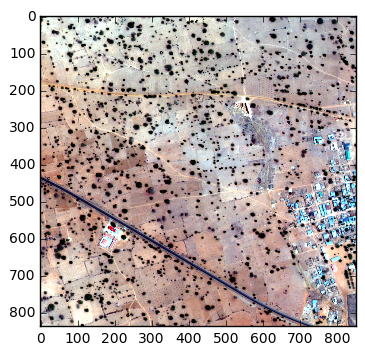

In [203]:
image_id = '6120_2_1'
m = M(image_id)
img = np.zeros((837,851,3))
img[:,:,0] = m[:,:,4] #red
img[:,:,1] = m[:,:,2] #green
img[:,:,2] = m[:,:,1] #blue
plt.imshow(stretch_8bit(img))

In [114]:
image_id = '6090_2_5'
m = M(image_id)
img = np.zeros((837,848,3))
img[:,:,0] = m[:,:,4] #red
img[:,:,1] = m[:,:,2] #green
img[:,:,2] = m[:,:,1] #blue
plt.imshow(stretch_8bit(img))

IOError: [Errno 2] No such file or directory: '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6090_2_5_M.tif'

In [15]:
__author__ = "n01z3"

import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

Using Theano backend.


In [42]:
N_Cls = 10
inDir = '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle' #'/home/n01z3/dataset/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission-3.csv'))
ISZ = 160
smooth = 1e-12

In [197]:
DF.ImageId.unique()

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'], dtype=object)

In [199]:
SB.ImageId.unique()

array(['6120_2_4', '6120_2_3', '6120_2_1', '6180_2_4', '6180_2_1',
       '6180_2_0', '6180_2_3', '6180_2_2', '6180_0_3', '6180_0_2',
       '6180_0_1', '6180_0_0', '6180_0_4', '6080_4_4', '6080_4_2',
       '6080_4_3', '6080_4_0', '6080_4_1', '6090_4_1', '6090_4_0',
       '6090_4_3', '6090_4_2', '6090_4_4', '6180_4_4', '6180_4_3',
       '6180_4_2', '6180_4_1', '6180_4_0', '6160_3_2', '6160_3_3',
       '6160_3_0', '6160_3_1', '6160_3_4', '6080_2_4', '6080_2_0',
       '6080_2_1', '6080_2_2', '6080_2_3', '6080_0_2', '6080_0_3',
       '6080_0_0', '6080_0_1', '6080_0_4', '6010_0_4', '6010_0_1',
       '6010_0_0', '6010_0_3', '6010_0_2', '6010_2_3', '6010_2_2',
       '6010_2_1', '6010_2_0', '6010_2_4', '6010_4_1', '6170_3_4',
       '6010_4_3', '6170_3_1', '6170_3_0', '6170_3_3', '6170_3_2',
       '6170_1_3', '6170_1_2', '6170_1_1', '6170_1_0', '6170_1_4',
       '6130_4_2', '6130_4_3', '6130_4_0', '6130_4_1', '6130_4_4',
       '6150_3_3', '6150_3_2', '6150_3_1', '6150_3_0', '6150_3

In [124]:
ID = []
for item in DF.ImageId.unique():
    ID.append(item.split('_')[0])
print set(ID)

set(['6010', '6070', '6110', '6100', '6150', '6040', '6140', '6060', '6120', '6160', '6090', '6170'])


In [123]:
ID_test = []
for item in SB.ImageId.unique():
    ID_test.append(item.split('_')[0])
print set(ID_test)

set(['6010', '6150', '6130', '6180', '6110', '6100', '6170', '6040', '6140', '6060', '6120', '6160', '6020', '6090', '6030', '6050', '6080', '6070'])


In [126]:
result = []
for item in set(ID):
    if item in set(ID_test):
        result.append(item)
        

In [130]:
set(result) ==set(ID)

True

12

In [196]:
SB.ImageId.unique

<bound method Series.unique of 0     6120_2_4
1     6120_2_4
2     6120_2_4
3     6120_2_4
4     6120_2_4
5     6120_2_4
6     6120_2_4
7     6120_2_4
8     6120_2_4
9     6120_2_4
10    6120_2_3
11    6120_2_3
12    6120_2_3
13    6120_2_3
14    6120_2_3
...
4275    6130_1_1
4276    6130_1_1
4277    6130_1_1
4278    6130_1_1
4279    6130_1_1
4280    6130_1_0
4281    6130_1_0
4282    6130_1_0
4283    6130_1_0
4284    6130_1_0
4285    6130_1_0
4286    6130_1_0
4287    6130_1_0
4288    6130_1_0
4289    6130_1_0
Name: ImageId, Length: 4290, dtype: object>

In [48]:
from os import path
def _get_image_names(base_path, imageId):
    '''
    Get the names of the tiff files
    '''
    d = {'3': path.join(base_path,'three_band/{}.tif'.format(imageId)),             # (3, 3348, 3403)
         'A': path.join(base_path,'sixteen_band/{}_A.tif'.format(imageId)),         # (8, 134, 137)
         'M': path.join(base_path,'sixteen_band/{}_M.tif'.format(imageId)),         # (8, 837, 851)
         'P': path.join(base_path,'sixteen_band/{}_P.tif'.format(imageId)),         # (3348, 3403)
         }
    return d

In [162]:
image = _get_image_names(inDir, '6120_2_2')

In [163]:
image

{'3': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif',
 'A': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_A.tif',
 'M': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_M.tif',
 'P': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_P.tif'}

In [53]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax,Ymax = xymax
    H,W = img_size
    W1 = 1.0*W*W/(W+1)
    H1 = 1.0*H*H/(H+1)
    xf = W1/Xmax
    yf = H1/Ymax
    coords[:,1] *= yf
    coords[:,0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0,1:].astype(float)
    return (xmax,ymin)

In [193]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from shapely.wkt import loads as wkt_loads
import tifffile as tiff


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

# The code is for python 2.7. Parts of it are taken from other posts/kernels.
# Good luck!


def _get_image_names(base_path, imageId):
    '''
    Get the names of the tiff files
    '''
    d = {'3': path.join(base_path,'three_band/{}.tif'.format(imageId)),             # (3, 3348, 3403)
         'A': path.join(base_path,'sixteen_band/{}_A.tif'.format(imageId)),         # (8, 134, 137)
         'M': path.join(base_path,'sixteen_band/{}_M.tif'.format(imageId)),         # (8, 837, 851)
         'P': path.join(base_path,'sixteen_band/{}_P.tif'.format(imageId)),         # (3348, 3403)
         }
    return d


def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax,Ymax = xymax
    H,W = img_size
    W1 = 1.0*W*W/(W+1)
    H1 = 1.0*H*H/(H+1)
    xf = W1/Xmax
    yf = H1/Ymax
    coords[:,1] *= yf
    coords[:,0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0,1:].astype(float)
    return (xmax,ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list,interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value = 1):
    img_mask = np.zeros(raster_img_size,np.uint8)
    if contours is None:
        return img_mask
    perim_list,interior_list = contours
    cv2.fillPoly(img_mask,perim_list,class_value)
    cv2.fillPoly(img_mask,interior_list,0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda,
                                     wkt_list_pandas):
    xymax = _get_xmax_ymin(grid_sizes_panda,imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas,imageId,class_type)
    contours = _get_and_convert_contours(polygon_list,raster_size,xymax)
    mask = _plot_mask_from_contours(raster_size,contours,1)
    return mask


inDir = '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle' #'/home/n01z3/dataset/dstl'

# read the training data from train_wkt_v4.csv
df = pd.read_csv(inDir + '/train_wkt_v4.csv')

# grid size will also be needed later..
gs = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)

#for i in range(10
for i in range(6):
    mask = np.zeros((3000,3200,3))
    mask[:,:,0] = generate_mask_for_image_and_class((3000,3200),"6120_2_" +str(i),4,gs,df)
    mask[:,:,1] = generate_mask_for_image_and_class((3000,3200),"6120_2_" +str(i),2,gs,df)
    mask[:,:,2] = generate_mask_for_image_and_class((3000,3200),"6120_2_" +str(i),1,gs,df)
    cv2.imwrite('_' + "6120_2_" +str(i) + "mask.png",mask*255)




IndexError: index 0 is out of bounds for axis 0 with size 0

In [78]:
mask.shape

(3000, 3200, 3)

In [171]:
image_path = _get_image_names(inDir, "6120_2_2")

In [172]:
image_path

{'3': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif',
 'A': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_A.tif',
 'M': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_M.tif',
 'P': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_P.tif'}

In [173]:
image_path.keys()

['A', 'P', '3', 'M']

In [176]:
image_path

{'3': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif',
 'A': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_A.tif',
 'M': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_M.tif',
 'P': '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_P.tif'}

In [177]:
path_key

'M'

In [184]:
image_dict = {}
for path_key in image_path.keys():
    image_path_read = image_path[path_key]
    print image_path_read
    path_image_item = tiff.imread(image_path_read)
    print path_image_item.shape
    image_dict[path_key] = path_image_item


/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_A.tif
(8, 134, 137)
/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_P.tif
(3348, 3403)
/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif
(3, 3348, 3403)
/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_M.tif
(8, 837, 851)


In [200]:
path_image_item.shape

(8, 837, 851)

In [185]:
image_dict.keys()

['A', 'P', '3', 'M']

In [186]:
1 + 1

2

In [187]:
image_dict['3']

array([[[660, 655, 648, ..., 718, 714, 718],
        [649, 653, 662, ..., 714, 713, 714],
        [656, 658, 672, ..., 716, 716, 720],
        ..., 
        [628, 630, 627, ..., 841, 839, 814],
        [633, 637, 636, ..., 840, 842, 829],
        [647, 643, 638, ..., 841, 850, 832]],

       [[511, 509, 505, ..., 548, 545, 547],
        [507, 508, 511, ..., 546, 544, 544],
        [511, 510, 517, ..., 547, 545, 546],
        ..., 
        [499, 500, 499, ..., 618, 618, 605],
        [500, 502, 502, ..., 617, 619, 613],
        [505, 503, 502, ..., 617, 622, 615]],

       [[354, 353, 352, ..., 371, 370, 370],
        [352, 353, 355, ..., 370, 370, 370],
        [355, 355, 359, ..., 371, 371, 371],
        ..., 
        [350, 353, 354, ..., 398, 399, 394],
        [352, 354, 355, ..., 397, 398, 397],
        [354, 354, 354, ..., 397, 401, 397]]], dtype=uint16)

In [137]:
img.shape

(3, 3348, 3403)

In [134]:
/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif 
/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif

image_dict[path_image] = Image.open('/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif ')

IOError: [Errno 2] No such file or directory: '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/three_band/6120_2_2.tif '

IOError: cannot identify image file '/Users/weizhi/Desktop/kaggle_code_combine/three_bands_kaggle/sixteen_band/6120_2_2_A.tif'

In [83]:
image_dict

{}

In [58]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [51]:
DF.head(30) #(250, 3)

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...
5,6040_2_2,6,MULTIPOLYGON EMPTY
6,6040_2_2,7,MULTIPOLYGON EMPTY
7,6040_2_2,8,MULTIPOLYGON EMPTY
8,6040_2_2,9,MULTIPOLYGON EMPTY
9,6040_2_2,10,MULTIPOLYGON EMPTY


In [52]:
GS.head(30) #(450, 3)

,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.009040
1,6120_2_3,0.009169,-0.009040
2,6120_2_2,0.009188,-0.009040
3,6120_2_1,0.009188,-0.009040
4,6120_2_0,0.009188,-0.009040
5,6180_2_4,0.009169,-0.009031
6,6180_2_1,0.009169,-0.009042
7,6180_2_0,0.009156,-0.009042
8,6180_2_3,0.009188,-0.009040
9,6180_2_2,0.009188,-0.009040


In [16]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


In [36]:
def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)

def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList

def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask
def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img

def stretch_n(bands, lower_percent=5, higher_percent=95):
    #out = np.zeros_like(bands)
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)



In [37]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)